<a href="https://colab.research.google.com/github/rehabreda/Projects/blob/master/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### import libraries 
import pandas as pd 
import numpy as np 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

In [0]:
## load data from drive
data=pd.read_csv('jobs_data.csv')


# check if there is null in data

In [3]:
data.isnull().sum()

Unnamed: 0     0
title          0
jobFunction    0
industry       0
dtype: int64

In [12]:
data.head()

,Unnamed: 0,title,jobFunction,industry
0,0,Full Stack PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Marketing and Advertisi..."
1,1,CISCO Collaboration Specialist Engineer,"['Installation/Maintenance/Repair', 'IT/Softwa...",['Information Technology Services']
2,2,Senior Back End-PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Computer Networking']"
3,3,UX Designer,"['Creative/Design/Art', 'IT/Software Developme...","['Computer Software', 'Information Technology ..."
4,4,Java Technical Lead,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Information Technology ..."


In [0]:
## clean function 
def clean(text):
    text=text.lower()  # make all characters small
    text=re.sub(r"\-\s[a-z]*"," ",text)
    text=re.sub(r"[^\w]"," ",text) ## remove non characters 
    text=re.sub(r'[\u0600-\u06FF]+',' ',text) ## remove arabic words 
    text=re.sub(r'\s+'," ",text) ## remove spaces 
    return text

In [0]:
data['title']=data['title'].apply(clean)

In [45]:
data['title']

0                          full stack php developer
1           cisco collaboration specialist engineer
2                     senior back end php developer
3                                       ux designer
4                               java technical lead
                            ...                    
10865                                odoo developer
10866                         senior php developer 
10867    sales account manager real estate medical 
10868       technical and network support engineer 
10869                         senior java developer
Name: title, Length: 10870, dtype: object

# one hot encoding for jobFunction

In [0]:
df_out = data.assign(**pd.get_dummies(data.jobFunction.apply(lambda x:pd.Series(x)).stack().reset_index(level=1,drop=True)).sum(level=0))

In [49]:
df_out.head()

,Unnamed: 0,title,jobFunction,industry,"['Accounting/Finance', 'Administration', 'Operations/Management']","['Accounting/Finance', 'Administration']","['Accounting/Finance', 'Analyst/Research']","['Accounting/Finance', 'Banking']","['Accounting/Finance', 'Business Development']","['Accounting/Finance', 'C-Level Executive/GM/Director']","['Accounting/Finance', 'Customer Service/Support', 'IT/Software Development']","['Accounting/Finance', 'Customer Service/Support']","['Accounting/Finance', 'Education/Teaching']","['Accounting/Finance', 'Engineering - Telecom/Technology', 'IT/Software Development']","['Accounting/Finance', 'Human Resources', 'Administration']","['Accounting/Finance', 'Human Resources']","['Accounting/Finance', 'IT/Software Development', 'Engineering - Telecom/Technology']","['Accounting/Finance', 'IT/Software Development', 'Strategy/Consulting']","['Accounting/Finance', 'IT/Software Development']","['Accounting/Finance', 'Logistics/Supply Chain']","['Accounting/Finance', 'Operations/Management']","['Accounting/Finance', 'Pharmaceutical']","['Accounting/Finance', 'Project/Program Management']","['Accounting/Finance', 'Quality', 'IT/Software Development']","['Accounting/Finance', 'Sales/Retail']","['Accounting/Finance', 'Strategy/Consulting', 'IT/Software Development']","['Accounting/Finance', 'Strategy/Consulting']",['Accounting/Finance'],"['Administration', 'Accounting/Finance']","['Administration', 'Business Development', 'Operations/Management']","['Administration', 'Customer Service/Support', 'Marketing/PR/Advertising']","['Administration', 'Customer Service/Support', 'Medical/Healthcare']","['Administration', 'Customer Service/Support', 'Operations/Management']","['Administration', 'Customer Service/Support', 'Sales/Retail']","['Administration', 'Customer Service/Support']","['Administration', 'Education/Teaching']","['Administration', 'Engineering - Construction/Civil/Architecture', 'Engineering - Mechanical/Electrical']","['Administration', 'Engineering - Construction/Civil/Architecture']","['Administration', 'Engineering - Telecom/Technology', 'IT/Software Development']","['Administration', 'Human Resources']",...,"['Sales/Retail', 'Operations/Management', 'Business Development']","['Sales/Retail', 'Operations/Management']","['Sales/Retail', 'Pharmaceutical', 'Engineering - Other']","['Sales/Retail', 'Pharmaceutical']","['Sales/Retail', 'Project/Program Management', 'Medical/Healthcare']","['Sales/Retail', 'R&D/Science', 'Medical/Healthcare']","['Sales/Retail', 'Tourism/Travel']","['Sales/Retail', 'Training/Instructor']",['Sales/Retail'],"['Sports and Leisure', 'Education/Teaching']","['Strategy/Consulting', 'Accounting/Finance']","['Strategy/Consulting', 'IT/Software Development', 'Engineering - Telecom/Technology']","['Tourism/Travel', 'Customer Service/Support', 'Sales/Retail']","['Tourism/Travel', 'Customer Service/Support']","['Tourism/Travel', 'Operations/Management']","['Tourism/Travel', 'Sales/Retail', 'Customer Service/Support']",['Tourism/Travel'],"['Training/Instructor', 'Creative/Design/Art']","['Training/Instructor', 'Education/Teaching', 'IT/Software Development']","['Training/Instructor', 'Education/Teaching']","['Training/Instructor', 'Engineering - Telecom/Technology', 'IT/Software Development']","['Training/Instructor', 'IT/Software Development']","['Training/Instructor', 'Marketing/PR/Advertising']","['Training/Instructor', 'Medical/Healthcare', 'Education/Teaching']","['Training/Instructor', 'Operations/Management', 'Education/Teaching']","['Training/Instructor', 'Sales/Retail']",['Training/Instructor'],"['Writing/Editorial', 'Education/Teaching', 'Medical/Healthcare']","['Writing/Editorial', 'Education/Teaching']","['Writing/Editorial', 'IT/Software Development', 'Engineering - Telecom/Technology']","['Writing/Editorial', 'Marketing/PR/Advertising', 'Creative/Design/Art']","['Writing/Editorial', 'Marketing/PR/Advertising', 'Media/Journalism/Publishing']","['Writing/Editorial', 'Marke

In [0]:
## rempve nan column
df_out=df_out.iloc[:,0:-1]

In [0]:
### split data to inputs(x)  and outputs(y)
x=df_out['title']
y=df_out.iloc[:,4:]


In [0]:
##split data 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)

In [54]:
### output shape 
y.shape

(10870, 835)

In [0]:
#### convert input text to vectors using TfidfVectorizer
tfid=TfidfVectorizer()
x_train_tfid=tfid.fit_transform(x_train)
x_test_tfid=tfid.transform(x_test)

In [0]:
## pickle TfidfVectorizer
import pickle 
with open('TfidfVectorizer.pkl','wb') as f:
    pickle.dump(tfid,f)


In [0]:
### try MultinomialNB classifier 
cls=OneVsRestClassifier(MultinomialNB())
cls.fit(x_train_tfid,y_train)

In [0]:
### use MultinomialNB to predict x_test 
predicted=cls.predict(x_test_tfid)

In [58]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,predicted)

print('MultinomialNB Classifier Accuracy is : {}'.format(acc))

MultinomialNB Classifier Accuracy is : 0.16651333946642136


In [0]:
##try randomforest  classifier 
from sklearn.ensemble import RandomForestClassifier
forest = OneVsRestClassifier(RandomForestClassifier(25))
forest.fit(x_train_tfid,y_train)

In [60]:
##use randomforest classifier to predict x_test 
pred=forest.predict(x_test_tfid)
acc=accuracy_score(y_test,pred)
print('RandomForest Classifier Accuracy is : {}'.format(acc))

RandomForest Classifier Accuracy is : 0.4107635694572217


In [0]:
### try support vector Classifier 
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.multiclass import OneVsRestClassifier
svc = OneVsRestClassifier(SVC(kernel='rbf'))
svc.fit(x_train_tfid, y_train)

In [63]:
pred=svc.predict(x_test_tfid)
acc=accuracy_score(y_test,pred)
print('Support Vector Classifier Accuracy is :'.format(acc))
acc


Support Vector Classifier Accuracy is :


0.013339466421343146

# deep learning model 

In [0]:
from sklearn.utils import class_weight

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data['jobFunction'].values),
                                                 data['jobFunction'].values)

In [0]:
### use tokenizier to convert inputs to sequences
from keras_preprocessing.text import Tokenizer
token=Tokenizer(num_words=1000)
token.fit_on_texts(x)

In [0]:
train_sequences=token.texts_to_sequences(x_train)
test_sequences=token.texts_to_sequences(x_test)

In [66]:
train_sequences[5]

[23, 10]

In [0]:
import pickle 
with open('Tokenizer.pkl','wb') as f:
    pickle.dump(token,f)

In [68]:
### pad sequences to make all sequences with the same length 
from keras.preprocessing.sequence import pad_sequences
x_train_padded=pad_sequences(train_sequences,maxlen=6,padding='post')
x_test_padded=pad_sequences(test_sequences,maxlen=6,padding='post')

Using TensorFlow backend.


In [69]:
x_train_padded[4]

array([ 31,  25,   9, 215,   0,   0], dtype=int32)

In [0]:
## deep learning model 
import keras
model=keras.models.Sequential()
model.add(keras.layers.Embedding(1000,300,input_length=6))
model.add(keras.layers.LSTM(units=32,return_sequences=True))
model.add(keras.layers.LSTM(units=64))
#model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(units=64,activation='relu'))
#model.add(keras.layers.Dropout(.2))
#model.add(keras.layers.Dense(units=128,activation='relu'))
#model.add(keras.layers.Dropout(.2))
#model.add(keras.layers.Dense(units=512,activation='relu'))
#model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(units=512,activation='relu'))
model.add(keras.layers.Dense(units=835 ,activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])


In [110]:
model.fit(x_train_padded,y_train,epochs=100,validation_data=(x_test_padded,y_test),class_weight=class_weights)

Train on 8696 samples, validate on 2174 samples
Epoch 1/100
8696/8696 [==============================] - 14s 2ms/step - loss: 4.3577 - acc: 0.1495 - val_loss: 3.8439 - val_acc: 0.1780
Epoch 2/100
8696/8696 [==============================] - 9s 992us/step - loss: 3.5850 - acc: 0.2544 - val_loss: 3.3660 - val_acc: 0.3086
Epoch 3/100
8696/8696 [==============================] - 9s 1ms/step - loss: 3.1326 - acc: 0.3352 - val_loss: 3.0272 - val_acc: 0.3579
Epoch 4/100
8696/8696 [==============================] - 9s 997us/step - loss: 2.8455 - acc: 0.3774 - val_loss: 2.8276 - val_acc: 0.3809
Epoch 5/100
8696/8696 [==============================] - 9s 991us/step - loss: 2.6592 - acc: 0.4012 - val_loss: 2.6973 - val_acc: 0.3924
Epoch 6/100
8696/8696 [==============================] - 9s 980us/step - loss: 2.5358 - acc: 0.4111 - val_loss: 2.6330 - val_acc: 0.4062
Epoch 7/100
8696/8696 [==============================] - 9s 989us/step - loss: 2.4377 - acc: 0.4204 - val_loss: 2.5833 - val_acc: 0.4

In [0]:
model.save('model.h5')

In [0]:
## load model 
from keras.models import load_model
new_model=load_model('model.h5')

C:\Users\rehab\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
with open('targets.pkl','rb') as f:
    targets=pickle.load(f)

In [0]:
word2int=token.word_index
int2word={value:key for key,value in word2int.items()}


In [0]:
def get_word(seq):
  seq=[i for i in seq if i!=0]
  sent=''
  for i in seq:
    word=int2word[i]
    sent+=' '+word
  return sent  




In [114]:
get_word(x_test_padded[10])

' housekeeping maintenance manager'

In [118]:
data['jobFunction'].value_counts()

['IT/Software Development', 'Engineering - Telecom/Technology']                1489
['Engineering - Telecom/Technology', 'IT/Software Development']                1113
['Sales/Retail']                                                                583
['Administration']                                                              395
['Accounting/Finance']                                                          370
                                                                               ... 
['Operations/Management', 'IT/Software Development', 'Strategy/Consulting']       1
['Logistics/Supply Chain', 'Operations/Management', 'Engineering - Other']        1
['Pharmaceutical', 'Analyst/Research', 'R&D/Science']                             1
['Operations/Management', 'Customer Service/Support', 'Sales/Retail']             1
['Operations/Management', 'Analyst/Research', 'Administration']                   1
Name: jobFunction, Length: 836, dtype: int64

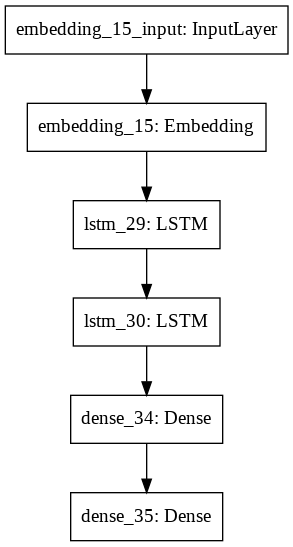

In [119]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')